# 사전학습 모델을 사용하여 개와 고양이 이미지 분류


## 1.데이터 준비하기

In [1]:
!pip install koreanize-matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 57.6 MB/s eta 0:00:00


In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import matplotlib.pyplot as plt
import koreanize_matplotlib
import os
import zipfile

import warnings
warnings.filterwarnings('ignore')

### Colab을 이용 - Google api를 통해 데이터 불러오기


In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2025-07-16 04:22:44--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.203.207, 74.125.199.207, 74.125.142.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.203.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   175MB/s    in 0.4s    

2025-07-16 04:22:45 (175 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



### 데이터 폴더 나누기(강아지 고양이 폴더 나누기)

#### 1) 압축풀기

In [4]:
# 1) 압축 풀기
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [5]:
# 2) 데이터 폴더 나누기
rootPath = '/tmp/cats_and_dogs_filtered'

# 훈련셋, 검증셋 경로
train_dir = os.path.join(rootPath, 'train') # /tmp/cats_and_dogs_filtered/train
validation_dir = os.path.join(rootPath, 'validation') # /tmp/cats_and_dogs_filtered/validation

# 훈련셋 중에 고양이 사진 경로
train_cats_dir = os.path.join(train_dir, 'cats') # /tmp/cats_and_dogs_filtered/train/cats
# 훈련셋 중에 강아지 사진 경로
train_dogs_dir = os.path.join(train_dir, 'dogs') # /tmp/cats_and_dogs_filtered/train/dogs

# 검증셋 중에 고양이 사진 경로
validation_cats_dir = os.path.join(validation_dir, 'cats') # /tmp/cats_and_dogs_filtered/validation/cats
# 검증셋 중에 강아지 사진 경로
validation_dogs_dir = os.path.join(validation_dir, 'dogs') # /tmp/cats_and_dogs_filtered/validation/dogs


### 데이터 확인하기

In [6]:
print('훈련 데이터 중 고양이 사진 수 : ', len(os.listdir(train_cats_dir)))
print('훈련 데이터 중 강아지 사진 수 : ', len(os.listdir(train_dogs_dir)))

print('검증 데이터 중 고양이 사진 수 : ', len(os.listdir(validation_cats_dir)))
print('검증 데이터 중 강아지 사진 수 : ', len(os.listdir(validation_dogs_dir)))

훈련 데이터 중 고양이 사진 수 :  1000
훈련 데이터 중 강아지 사진 수 :  1000
검증 데이터 중 고양이 사진 수 :  500
검증 데이터 중 강아지 사진 수 :  500


### 이미지 학습을 위한 훈련 데이터 검증 데이터 로드

In [7]:
import tensorflow as tf

img_size = (160, 160)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [8]:
class_names = train_ds.class_names
print("클래스:", class_names)

클래스: ['cats', 'dogs']


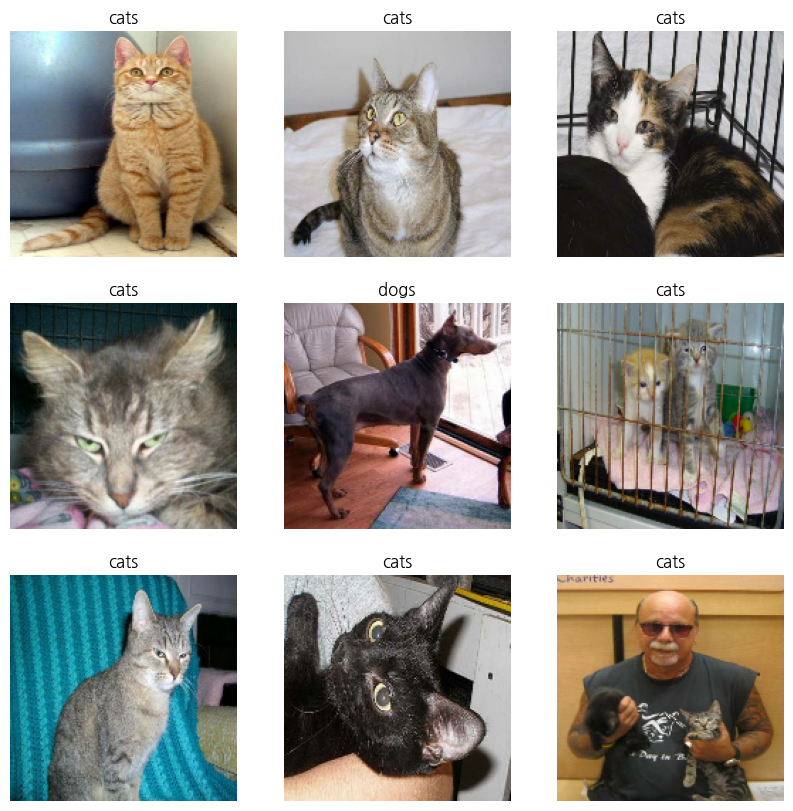

In [9]:
# 샘플 이미지 몇 장 확인
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(2):
    for i in range(9):  # 9장 표시
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

##2.모델 구성 및 설정

In [10]:
base_model = tf.keras.applications.MobileNetV2(input_shape=img_size + (3,),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False  # 사전학습된 부분은 고정

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


## 3. 모델 학습

In [12]:
epochs = 7
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/7
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 223ms/step - accuracy: 0.5832 - loss: 0.6947 - val_accuracy: 0.7260 - val_loss: 0.5487
Epoch 2/7
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.7463 - loss: 0.5255 - val_accuracy: 0.7560 - val_loss: 0.5061
Epoch 3/7
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7764 - loss: 0.4799 - val_accuracy: 0.7610 - val_loss: 0.4936
Epoch 4/7
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7788 - loss: 0.4755 - val_accuracy: 0.7690 - val_loss: 0.4774
Epoch 5/7
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.7965 - loss: 0.4412 - val_accuracy: 0.7960 - val_loss: 0.4570
Epoch 6/7
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.8073 - loss: 0.4294 - val_accuracy: 0.8010 - val_loss: 0.4502
Epoch 7/7
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.8177 - loss: 0.4140 - val_accuracy: 0.7730 - val_loss: 0.4637


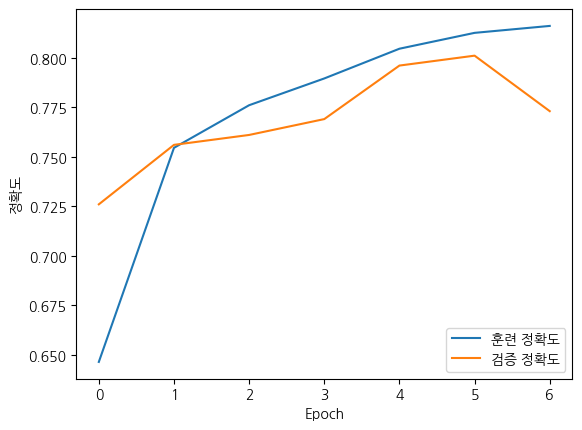

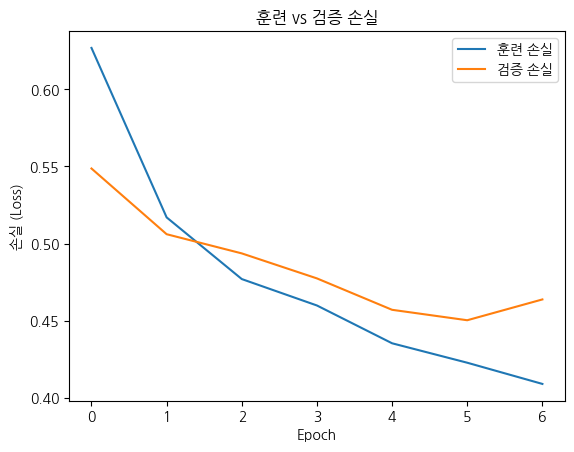

In [13]:
plt.plot(history.history['accuracy'], label='훈련 정확도')
plt.plot(history.history['val_accuracy'], label='검증 정확도')
plt.xlabel('Epoch')
plt.ylabel('정확도')
plt.legend(loc='lower right')
plt.show()

# 손실값(loss) 그래프
plt.plot(history.history['loss'], label='훈련 손실')
plt.plot(history.history['val_loss'], label='검증 손실')
plt.xlabel('Epoch')
plt.ylabel('손실 (Loss)')
plt.legend(loc='upper right')
plt.title('훈련 vs 검증 손실')
plt.show()


##4.모델 성능평가

### 혼동행렬

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━

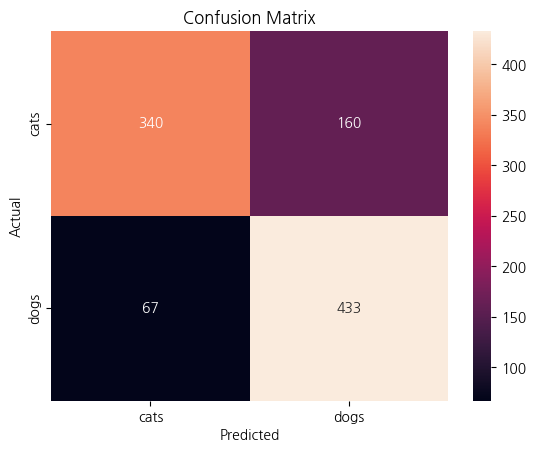

In [14]:
# 예측값과 실제 라벨 추출
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype('int').flatten())  # sigmoid → 0 or 1

# 혼동 행렬
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [21]:
# 분류 보고서
print(classification_report(y_true, y_pred, target_names=class_names))
# >>생명관련x 정밀도 확인

              precision    recall  f1-score   support

        cats       0.84      0.68      0.75       500
        dogs       0.73      0.87      0.79       500

    accuracy                           0.77      1000
   macro avg       0.78      0.77      0.77      1000
weighted avg       0.78      0.77      0.77      1000



In [22]:
from sklearn import metrics

# 예측값과 실제 라벨 추출
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype('int').flatten())  # sigmoid → 0 or 1


print('accuracy : ', metrics.accuracy_score(y_true, y_pred))
print('precision : ', metrics.precision_score(y_true, y_pred))
print('recall : ', metrics.recall_score(y_true, y_pred))
print('f1 : ', metrics.f1_score(y_true, y_pred))

wrong_images = []
wrong_preds = []
wrong_labels = []

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━

##5.이미지 예측하기

In [23]:

# 예측 함수
def predict_image(img_path, model, class_names, img_size=(160, 160)):
    # 이미지 로딩 및 전처리
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # (1, 160, 160, 3)
    img_array = img_array / 255.0  # Rescale

    # 예측
    prediction = model.predict(img_array)[0][0]
    predicted_class = 1 if prediction > 0.5 else 0
    predicted_label = class_names[predicted_class]

    # 출력
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"예측: {predicted_label} ({prediction:.2f})")
    plt.show()

    return predicted_class, prediction

Saving 검강.jfif to 검강 (1).jfif
파일명: 검강 (1).jfif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


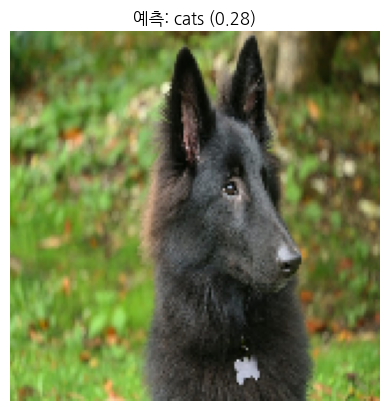

In [29]:
from google.colab import files

# ✅ 이미지 업로드
uploaded = files.upload()  # 사용자에게 파일 업로드 창 제공

# ✅ 첫 번째 업로드 파일 예측
for file_name in uploaded.keys():
    print(f"파일명: {file_name}")
    predict_image(file_name, model, class_names)
    break  # 첫 파일만 실행